### Import the necessary libraries

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras import layers, models
import requests
import matplotlib.pyplot as plt

### Loading the data

In [39]:
# load the data locally
df = pd.read_pickle('data/words_df_all.pkl.gz')

In [3]:
"""# Load the data in Google Colab

# first, upload the words_df_all.pkl.gz to Google Drive
# then, run the following code in Google Colab
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Read the file from Google Drive
file_path = '/content/drive/MyDrive/words_df_all.pkl.gz'
df = pd.read_pickle(file_path)"""

"# Load the data in Google Colab\n\n# first, upload the words_df_all.pkl.gz to Google Drive\n# then, run the following code in Google Colab\n# Mount Google Drive\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\n# Read the file from Google Drive\nfile_path = '/content/drive/MyDrive/words_df_all.pkl.gz'\ndf = pd.read_pickle(file_path)"

In [40]:
df.head()

,WordID,SegmentationResult,GrayLevel,BoundingBox,GrammaticalTag,Transcription,ImageData
0,a01-000u-00-00,ok,154,"(408, 768, 27, 51)",AT,A,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
1,a01-000u-00-01,ok,154,"(507, 766, 213, 48)",NN,MOVE,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
2,a01-000u-00-02,ok,154,"(796, 764, 70, 50)",TO,to,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
3,a01-000u-00-03,ok,154,"(919, 757, 166, 78)",VB,stop,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
4,a01-000u-00-04,ok,154,"(1185, 754, 126, 61)",NPT,Mr.,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


### Neural Networks

**On shapes...**

**CNNs**

- Always have to give a 4D array as input to the CNN. So input data has a shape of (batch_size, height, width, depth).

- The output of the CNN is also a 4D array. Where batch size would be the same as input batch size but the other 3 dimensions of the image might change depending upon the values of filter, kernel size, and padding we use. (batch_size, height, width, depth)

- Input data to the dense layer 2D must be an array of shape (batch_size, units). And the output of the convolution layer is a 4D array. Thus we have to change the dimension of output received from the convolution layer to a 2D array.


<img src="convnet_input.png" width="500" height="400">

**RNNs**

- Always have to give a 3D array as an input to the LSTM network. 

- The first dimension represents the batch size, the second dimension represents the time-steps and the third dimension represents the number of units in one input sequence. For example, the input shape looks like (batch_size, time_steps, units).

- The output of the LSTM could be a 2D array or 3D array depending upon the return_sequences argument.

- return_sequence argument: Tells whether to return the output at each time step instead of the final time step. 

- If return_sequence is False, the output is a 2D array. (batch_size, units)

- If return_sequence is True, the output is a 3D array. (batch_size, time_steps, units)


<img src="LSTM_input.png" width="500" height="400">


Function to plot the model Training and Validation Loss and Accuracy

In [41]:
# Function: Plotting the Training and Validation Loss and Accuracy
def plot_history(history):
    # Get training and test loss histories
    training_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, val_loss, 'b-')
    plt.legend(['Training Loss', 'Val Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # Get training and test accuracy histories
    training_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Visualize accuracy history
    plt.plot(epoch_count, training_accuracy, 'r--')
    plt.plot(epoch_count, val_accuracy, 'b-')
    plt.legend(['Training Accuracy', 'Val Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

### A: **1 character** words model

In [42]:
# randomize the order of the rows in the df
df_char = df.sample(frac=1).reset_index(drop=True)

# consider only one-character words in the df
df_char = df_char[df_char['Transcription'].apply(len) == 1]

# consider only SegmentationResluts == 'ok'
df_char = df_char[df_char['SegmentationResult'] == 'ok']

# Split data into training and validation sets
X = np.stack(df_char['ImageData'].values)  # Convert the list of images to a numpy array
y = df_char['Transcription'].values

In [43]:
print(len(df_char))

14172


**Encode** the characters to integers. 

Example: '!' -> 1, '"' -> 2, etc.

In [44]:
# get the vocabulary list
vocabulary = sorted(set(''.join(y)))

# create a dictionary mapping each character to the vocabulary list index. do not use 0.
char_to_num = {char: idx for idx, char in enumerate(vocabulary)}

print(char_to_num)

# subsitute the characters in y with the corresponding number. example: '!' -> 1, '"' -> 2, etc." each label value is an integer
y = [char_to_num[char] for char in y]

# y to np.array
y = np.array(y)

print(y)

{'!': 0, '"': 1, '#': 2, '&': 3, "'": 4, '(': 5, ')': 6, '*': 7, ',': 8, '-': 9, '.': 10, '1': 11, '2': 12, '3': 13, '4': 14, '5': 15, '6': 16, '7': 17, '8': 18, '9': 19, ':': 20, ';': 21, '?': 22, 'A': 23, 'B': 24, 'C': 25, 'D': 26, 'E': 27, 'F': 28, 'G': 29, 'H': 30, 'I': 31, 'J': 32, 'K': 33, 'L': 34, 'N': 35, 'O': 36, 'V': 37, 'a': 38, 'c': 39, 'x': 40}
[38  8  8 ...  8  8 38]


In [45]:
print(len(vocabulary))

41


In [46]:
print(vocabulary)

['!', '"', '#', '&', "'", '(', ')', '*', ',', '-', '.', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'N', 'O', 'V', 'a', 'c', 'x']


In [47]:
TRAIN_SPLIT = 0.9
VAL_SPLIT = 0.05
TEST_SPLIT = 0.05

# split the data into training, validation and test sets
X_train = X[:int(X.shape[0]*TRAIN_SPLIT)]
y_train = y[:int(y.shape[0]*TRAIN_SPLIT)]

X_val = X[int(X.shape[0]*TRAIN_SPLIT):int(X.shape[0]*(TRAIN_SPLIT+VAL_SPLIT))]
y_val = y[int(y.shape[0]*TRAIN_SPLIT):int(y.shape[0]*(TRAIN_SPLIT+VAL_SPLIT))]

X_test = X[int(X.shape[0]*(TRAIN_SPLIT+VAL_SPLIT)):]
y_test = y[int(y.shape[0]*(TRAIN_SPLIT+VAL_SPLIT)):]

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(12754, 32, 128, 1)
(12754,)
(709, 32, 128, 1)
(709,)
(709, 32, 128, 1)
(709,)


#### A: Model

In [48]:
def create_model(num_classes):
    model = Sequential([
        # Convolutional layer learns 32 filters using a 3x3 kernel
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 128, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        #Dropout(0.25),

        # Adding a second convolutional layer with 64 filters
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #Dropout(0.25),

        # Flatten the 3D output to 1D and add a dense layer
        Flatten(),
        Dense(128, activation='relu'),
        #Dropout(0.5),
        Dropout(0.1),

        # Output layer with softmax activation for classification
        Dense(num_classes, activation='softmax')
    ])
    # adam with a learning rate of 0.001

    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

num_classes = len(char_to_num)
model = create_model(num_classes)

# Save the best model during the training
best_model_path = 'best_model_char.h5'  
model_checkpoint = ModelCheckpoint(best_model_path, 
                                   monitor='val_loss', 
                                   save_best_only=True, 
                                   verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # You can set this to a higher number.
    batch_size=128,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50


100/100 [==============================] - ETA: 0s - loss: 1.3503 - accuracy: 0.6549
Epoch 1: val_loss improved from inf to 0.93468, saving model to best_model_char.h5
100/100 [==============================] - 9s 82ms/step - loss: 1.3503 - accuracy: 0.6549 - val_loss: 0.9347 - val_accuracy: 0.7377
Epoch 2/50
  1/100 [..............................] - ETA: 7s - loss: 0.7455 - accuracy: 0.7969

c:\Users\t.ferreira\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - ETA: 0s - loss: 0.7945 - accuracy: 0.7714
Epoch 2: val_loss improved from 0.93468 to 0.71796, saving model to best_model_char.h5
100/100 [==============================] - 8s 81ms/step - loss: 0.7945 - accuracy: 0.7714 - val_loss: 0.7180 - val_accuracy: 0.7983
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.6386 - accuracy: 0.8169
Epoch 3: val_loss improved from 0.71796 to 0.58879, saving model to best_model_char.h5
100/100 [==============================] - 8s 76ms/step - loss: 0.6386 - accuracy: 0.8169 - val_loss: 0.5888 - val_accuracy: 0.8223
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.5466 - accuracy: 0.8447
Epoch 4: val_loss improved from 0.58879 to 0.54710, saving model to best_model_char.h5
100/100 [==============================] - 8s 84ms/step - loss: 0.5466 - accuracy: 0.8447 - val_loss: 0.5471 - val_accuracy: 0.8378
Epoch 5/50
100/100 [==============================] - ETA: 0s - lo

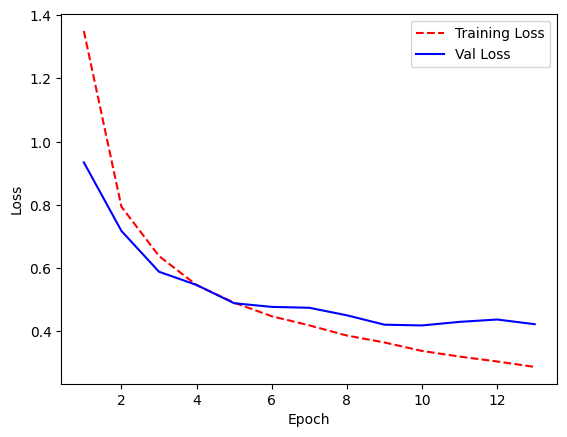

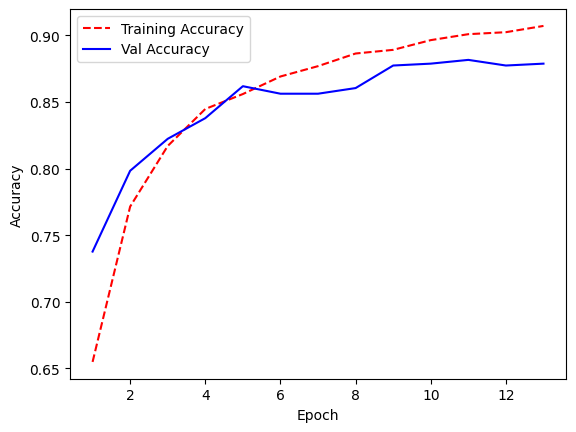

In [49]:
plot_history(history)

## Hyper Parameter Tuning - 1 Character

In [50]:
import keras_tuner as kt

In [51]:
def create_model(num_classes):
    model = Sequential([
        # Convolutional layer learns 32 filters using a 3x3 kernel
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 128, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        #Dropout(0.25),

        # Adding a second convolutional layer with 64 filters
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #Dropout(0.25),

        # Flatten the 3D output to 1D and add a dense layer
        Flatten(),
        Dense(128, activation='relu'),
        #Dropout(0.5),
        Dropout(0.1),

        # Output layer with softmax activation for classification
        Dense(num_classes, activation='softmax')
    ])
    # adam with a learning rate of 0.001sparse_categorical_crossentropy

    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='',
                  metrics=['accuracy'])
    return model

Model Building Function to be used under Keras Tuner.




In [56]:
def model_builder_hyper_1char(hp):
    seq_to_seq_model = Sequential()
    
    seq_to_seq_model.add(Conv2D(hp.Int('Input CNN units', min_value=64, max_value=128, step=32), kernel_size=(3, 3), input_shape=(32, 128, 1), activation="relu", padding="SAME"))
    seq_to_seq_model.add(MaxPooling2D(pool_size=(2, 2)))
    for i in range(hp.Int("layers", 1 , 3)):
        seq_to_seq_model.add(Conv2D(hp.Int('CNN units ' + str(i), min_value=64, max_value=128, step=32), kernel_size=(3, 3), activation="relu", padding="SAME"))
        seq_to_seq_model.add(MaxPooling2D(pool_size=(2, 2)))
    seq_to_seq_model.add(Flatten())
    seq_to_seq_model.add(Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    seq_to_seq_model.add(Dropout(0.1))
    seq_to_seq_model.add(Dense(num_classes, activation="softmax"))

    seq_to_seq_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return seq_to_seq_model

Tuner using a max of 20 trials (combinations). Using Val accuracy as objective.

In [ ]:
tuner_1char = kt.RandomSearch(
    model_builder_hyper_1char,
    objective='val_accuracy',
    max_trials=10,  #Number of experiments
    directory='my_dir_hyper_1char',
    project_name='seq_to_seq_model_1char',
    seed=24
)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

tuner_1char.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

Trials Summary Results


In [ ]:
tuner_1char.results_summary()

New Model with the best Hyper-Parameters

In [ ]:
best_hps_1char = tuner_1char.get_best_hyperparameters(num_trials=10)[0]
seq_to_seq_model_1char = tuner_1char.hypermodel.build(best_hps_1char)

seq_to_seq_model_1char.summary()

In [ ]:
print("Best hyperparameters:", best_hps_1char.values)

In [61]:
# Save the best model during the training
best_hyper_model_path = 'best_hyper_model_1char.h5'  # Specify the path where you want to save the best model
model_checkpoint = ModelCheckpoint(best_hyper_model_path, 
                                   monitor='val_loss', 
                                   save_best_only=True, 
                                   verbose=1)


In [ ]:
# Fitting the new hyper tuned model to training data
history_2 = seq_to_seq_model_1char.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # replace with your validation data
    epochs=50,  # Set a high number because early stopping will halt the training
    batch_size=64,  # Adjust based on your data and computing resources
    callbacks=[early_stopping, model_checkpoint]  # Add the model checkpoint callback here
)


#### A: Testing the model with test data

In [674]:
"""num_to_char = {num: char for char, num in char_to_num.items()}
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
predicted_transcriptions = [num_to_char[num] for num in predicted_classes]
real_transcriptions = [num_to_char[num] for num in y_test]
for real, predicted in zip(real_transcriptions, predicted_transcriptions):
    print(f"Real: {real}")
    print(f"Predicted: {predicted}\n")
"""

'num_to_char = {num: char for char, num in char_to_num.items()}\npredictions = model.predict(X_test)\npredicted_classes = np.argmax(predictions, axis=1)\npredicted_transcriptions = [num_to_char[num] for num in predicted_classes]\nreal_transcriptions = [num_to_char[num] for num in y_test]\nfor real, predicted in zip(real_transcriptions, predicted_transcriptions):\n    print(f"Real: {real}")\n    print(f"Predicted: {predicted}\n")\n'

In [70]:
import pandas as pd

# Create a reverse mapping from number to character
num_to_char = {num: char for char, num in char_to_num.items()}

# Uncoment the lines below to run test data vs the hypertuned model.
"""
from keras.models import load_model
model = load_model('best_hyper_model_1char.h5')
"""

# Uncoment the lines below to run test data vs the baseline model.
"""
from keras.models import load_model
model = load_model('best_model_char.h5')
"""

# Make predictions on the test data - Use This if su
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Decode the predictions into actual characters
predicted_transcriptions = [num_to_char.get(num, '') for num in predicted_classes]
real_transcriptions = [num_to_char.get(num, '') for num in y_test]

# Determine if the prediction is correct (1) or not (0)
correct_predictions = [1 if real == pred else 0 for real, pred in zip(real_transcriptions, predicted_transcriptions)]

# Get the indices for the test set
test_indices = range(int(len(df_char) * (TRAIN_SPLIT + VAL_SPLIT)), len(df_char))

# Ensure that the lengths of your test labels and indices match
assert len(test_indices) == len(y_test), "Mismatch in test set size and actual labels"

# Extract WordIDs and ImgageData for the test set using the correct indices
test_word_ids = df.iloc[test_indices]['WordID'].values
test_img_data = df.iloc[test_indices]['ImageData'].values

# Ensure that every list you're going to put into the DataFrame is of the same length
assert len(test_word_ids) == len(test_img_data) == len(predicted_transcriptions) == len(real_transcriptions), "Mismatch in the length of data columns"

# Create the DataFrame
results_df = pd.DataFrame({
    'WordID': test_word_ids,
    'Real': real_transcriptions,
    'Predicted': predicted_transcriptions,
    'Correct': correct_predictions,
    'ImageData': test_img_data
})

# Display the first few rows of the DataFrame
results_df.head()

5/5 [==============================] - 0s 9ms/step


,WordID,Real,Predicted,Correct,ImageData
0,j01-059-05-08,-,-,1,"[[[0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1..."
1,e04-119-01-03,a,a,1,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
2,m01-049-01-04,a,a,1,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
3,n03-103-02-03,a,a,1,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
4,d05-040-04-02,a,a,1,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


In [72]:
print(results_df['Correct'].value_counts())
print(results_df['Correct'].value_counts() / len(results_df))

Correct
1    141
0     15
Name: count, dtype: int64
Correct
1    0.903846
0    0.096154
Name: count, dtype: float64


In [687]:
incorrect = results_df[results_df['Correct'] == 0]
incorrect.head()

,WordID,Real,Predicted,Correct,ImageData
0,b02-013-07-06,I,",",0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
7,b02-013-08-05,"""",',0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
15,b02-013-09-06,",",I,0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
16,b02-013-09-07,A,"""",0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
17,b02-035-00-00,",",a,0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


In [690]:
print(len(results_df))

1807


In [691]:
results_df.to_csv('results_char.csv')

In [694]:
# print evaluation metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81        28
           1       0.86      0.72      0.78       169
           2       0.80      0.50      0.62         8
           3       1.00      0.50      0.67         4
           4       0.17      0.01      0.02        80
           5       0.71      0.59      0.65        17
           6       0.70      0.39      0.50        18
           8       0.78      0.90      0.84       563
           9       0.84      0.95      0.89        40
          10       0.90      0.90      0.90       510
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         3
          13       1.00      0.67      0.80         3
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         2
          20       0.76      0.94      0.84        17
          21       0.83    

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **1 or more characters** words

In [194]:
# load the data
df = pd.read_pickle('data/words_df_all.pkl.gz')

In [195]:
# consider only SegmentationResluts == 'ok'
df = df[df['SegmentationResult'] == 'ok']

In [196]:
for i, img in enumerate(df['ImageData']):
    if type(img) != np.ndarray:
        print(df['WordID'][i])
        # delete the current row from df
        df.drop(i, inplace=True)

a01-096u-04-02
m03-062-07-02


In [197]:
# print the row in which imagdate is none
df[df['ImageData'].isnull()]

,WordID,SegmentationResult,GrayLevel,BoundingBox,GrammaticalTag,Transcription,ImageData
4152,a01-117-05-02,ok,160,"(868, 1648, 217, 86)",NP,Powell,None
113621,r06-022-03-05,ok,184,"(924, 1304, 132, 29)",QL,more,None


In [198]:
df = df[df['ImageData'].notnull()]

In [178]:
print(df['ImageData'].apply(type).value_counts())

ImageData
<class 'numpy.ndarray'>    115317
Name: count, dtype: int64


In [179]:
print(len(df['Transcription'].unique()))

13549


In [182]:
vocabulary = sorted(set(''.join(df['Transcription'].values)))
print(vocabulary)

[' ', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [199]:
# shuffle
df = df.sample(frac=1).reset_index(drop=True)

In [200]:
# consider only words that do not contain spaces or pontuation
punctuation = [' ', '.', ',', '!', '?', "'", '"', '(', ')', '[', ']', '{', '}', '/', '\\', '|', '*', '+', '=', '_', '#', '@', '%', '&', '^', '~', '`', '<', '>', ':', ';']
df = df[df['Transcription'].apply(lambda x: all(char not in x for char in punctuation))]

In [201]:
# Split data into training and validation sets
X = np.stack(df['ImageData'].values)  # Convert the list of images to a numpy array
y = np.array(df['Transcription'].values)

In [202]:
def encode_to_labels(y):
    global vocabulary, char_to_num
    # create a list of the chartcaters vocabulary ordered alphabetically
    vocabulary = sorted(set(''.join(y)))

    # create a dictionary mapping each character to the vocabulary list index. do not use 0.
    char_to_num = {char:idx+1 for idx, char in enumerate(vocabulary)}

    # transform y values to numerical using the char_to_num dictionary, using 0 for padding. the length of each word is the maximum length of the words in the dataset
    y_encoded = []
    for word in y:
        word_encoded = [char_to_num[char] for char in word]
        y_encoded.append(word_encoded)

    # pad the encoded values (fill with 0s to the right)
    y_encoded = tf.keras.preprocessing.sequence.pad_sequences(y_encoded, padding='post')

    # normalize the values
    # y_encoded = y_encoded / np.array(len(vocabulary))

    return y_encoded

y = encode_to_labels(y)

# one-hot enconde instead of encode_to_labels
# y = to_categorical(y, num_classes=len(vocabulary)+1)

# print(y.shape)

# add padding to y to match the image size
# y = np.pad(y, ((0,0),(0,32-y.shape[1]),(0,0)), mode='constant', constant_values=0)

print(y.shape)

(83831, 21)


In [203]:
print(y[4])

[46 51  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [204]:
print(X.shape)
print(y.shape)

(83831, 32, 128, 1)
(83831, 21)


In [205]:
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1

# split the data into training, validation and test sets
X_train = X[:int(X.shape[0]*TRAIN_SPLIT)]
y_train = y[:int(y.shape[0]*TRAIN_SPLIT)]

X_val = X[int(X.shape[0]*TRAIN_SPLIT):int(X.shape[0]*(TRAIN_SPLIT+VAL_SPLIT))]
y_val = y[int(y.shape[0]*TRAIN_SPLIT):int(y.shape[0]*(TRAIN_SPLIT+VAL_SPLIT))]

X_test = X[int(X.shape[0]*(TRAIN_SPLIT+VAL_SPLIT)):]
y_test = y[int(y.shape[0]*(TRAIN_SPLIT+VAL_SPLIT)):]

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(67064, 32, 128, 1)
(67064, 21)
(8383, 32, 128, 1)
(8383, 21)
(8384, 32, 128, 1)
(8384, 21)


In [121]:
# save value_counts of transcription of df to a df and export it to txt
df['Transcription'].value_counts().to_csv('data/transcription_value_counts_all.txt', header=None, sep=' ')

In [122]:
# print the shapes of training x and y
print(X_train.shape)
print(y_train.shape)

(67064, 32, 128, 1)
(67064, 21)


In [123]:
print(y_train[0])

[31 45 42 55 42  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [206]:
# one hot encode y
y_train = to_categorical(y_train, num_classes=len(vocabulary)+1)
y_val = to_categorical(y_val, num_classes=len(vocabulary)+1)
y_test = to_categorical(y_test, num_classes=len(vocabulary)+1)

print(y_train.shape)

(67064, 21, 64)


In [125]:
y_train[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

#### Baseline Model

In [27]:
# save y_train[0] to txt file
np.savetxt('data/y_train_0.txt', y_train[2], fmt='%d')

In [31]:
# ---- DESCRIPTION OF THE INPUT DATA ----
# X_train shape: (num_samples, 32, 128, 1)
# y_train shape: (num_samples, max(len(words)),len(vocabulary))
# example of a X_train value: matrix of 32x128 with values between 0 and 1
# example of a y_train value: matrix of 17x63 with values between 0 and 1. first column is the padding, the rest are the one-hot encoded values of the transcription

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import Reshape

def create_cnn_model(input_shape, num_classes, sequence_length):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        
        Dense(256, activation='relu'),
        Dropout(0.1),
        
        Dense(sequence_length * num_classes, activation='softmax'),
        Reshape((sequence_length, num_classes))


    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

create_cnn_model(input_shape=(32, 128, 1), num_classes=len(vocabulary)+1, sequence_length=y_train.shape[1]).summary()


from keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Stop training when there is no improvement in the validation loss for 3 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Save the best model during the training
best_model_path = 'best_model_word.h5'  
model_checkpoint = ModelCheckpoint(best_model_path, 
                                   monitor='val_loss', 
                                   save_best_only=True, 
                                   verbose=1)

# Assume create_cnn_model is a function you've defined to create your model
model = create_cnn_model(input_shape=(32, 128, 1), num_classes=len(vocabulary)+1, sequence_length=y_train.shape[1])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Set a high number because early stopping will halt the training
    batch_size=128,
    callbacks=[early_stopping, model_checkpoint]  # Add the model checkpoint callback here
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 126, 32)       320       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 15, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 61, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 6, 30, 64)         0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 28, 128)        73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 2, 14, 128)       

Epoch 1/50
524/524 [==============================] - ETA: 0s - loss: 0.7950 - accuracy: 0.7948
Epoch 1: val_loss improved from inf to 0.67016, saving model to best_model_word.h5
524/524 [==============================] - 57s 108ms/step - loss: 0.7950 - accuracy: 0.7948 - val_loss: 0.6702 - val_accuracy: 0.8106
Epoch 2/50


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


524/524 [==============================] - ETA: 0s - loss: 0.6564 - accuracy: 0.8164
Epoch 2: val_loss improved from 0.67016 to 0.61911, saving model to best_model_word.h5
524/524 [==============================] - 60s 114ms/step - loss: 0.6564 - accuracy: 0.8164 - val_loss: 0.6191 - val_accuracy: 0.8224
Epoch 3/50
524/524 [==============================] - ETA: 0s - loss: 0.6146 - accuracy: 0.8251
Epoch 3: val_loss improved from 0.61911 to 0.58120, saving model to best_model_word.h5
524/524 [==============================] - 60s 114ms/step - loss: 0.6146 - accuracy: 0.8251 - val_loss: 0.5812 - val_accuracy: 0.8303
Epoch 4/50
524/524 [==============================] - ETA: 0s - loss: 0.5832 - accuracy: 0.8314
Epoch 4: val_loss improved from 0.58120 to 0.55343, saving model to best_model_word.h5
524/524 [==============================] - 59s 112ms/step - loss: 0.5832 - accuracy: 0.8314 - val_loss: 0.5534 - val_accuracy: 0.8381
Epoch 5/50
524/524 [==============================] - ETA: 0

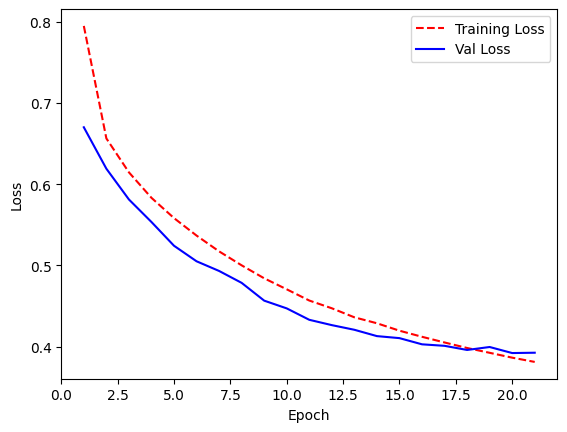

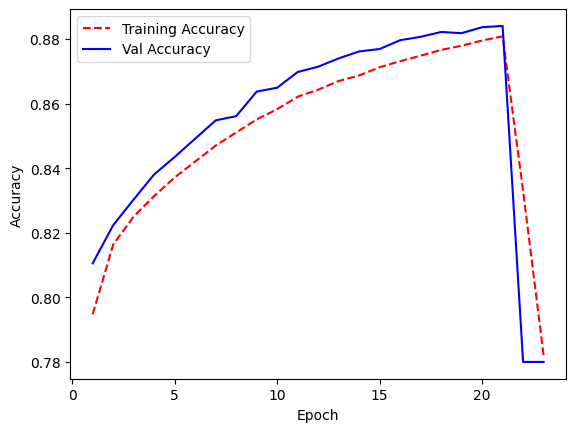

In [32]:
plot_history(history)

## Hyper Parameter Tuning - 1 or more chareter word Model

In [ ]:
import keras_tuner as kt

Model Building Functio to be used under Keras TUuer.

- Testing 1 Input CNN Layer. Neurous between 32 and 128 with a step of 32.
- Testing between 2 and 4 CNN layers. Neurous between 32 and 128 with a step of 32.
- Testing 1 DEnse layer. Neurous between 32 and 128 with a step of 32.
- Testing different dropout rates betqeen 0 and 0,5 with a step of 0,1.
- Testing 3 different learning rates [1e-1, 1e-2, 1e-3, 1e-4]



In [ ]:
def model_builder(hp):
    seq_to_seq_model = Sequential()
    
    seq_to_seq_model.add(Conv2D(hp.Int('Input CNN units', min_value=32, max_value=128, step=32), kernel_size=(3, 3), input_shape=(32, 128, 1), activation="relu"))
    seq_to_seq_model.add(MaxPooling2D(pool_size=(2, 2)))
    for i in range(hp.Int("layers", 2 , 4)):
        seq_to_seq_model.add(Conv2D(hp.Int('CNN units ' + str(i), min_value=32, max_value=128, step=32), kernel_size=(3, 3), activation="relu"))
        seq_to_seq_model.add(MaxPooling2D(pool_size=(2, 2)))
    seq_to_seq_model.add(Flatten())
    seq_to_seq_model.add(Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    seq_to_seq_model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)))
    seq_to_seq_model.add(Dense((17 * (len(vocabulary)+1)), activation="softmax"))
    seq_to_seq_model.add(Reshape((17,len(vocabulary)+1)))

    seq_to_seq_model.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning rate", values=[1e-1, 1e-2, 1e-3, 1e-4])), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return seq_to_seq_model

Tuner using a max of 20 trials (combinations). Using Val accuracy as objective.

In [ ]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=20,  #Number of experiments
    directory='my_dir',
    project_name='seq_to_seq_model',
    seed=24
)

tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Trial 2 Complete [00h 12m 41s]
val_accuracy: 0.8344508409500122

Best val_accuracy So Far: 0.8344508409500122
Total elapsed time: 00h 12m 41s


Trials Summary Results


In [ ]:
tuner.results_summary()

New Model with the best Hyper-Parametera

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=2)[0]
seq_to_seq_model2 = tuner.hypermodel.build(best_hps)

seq_to_seq_model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 126, 32)       320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 15, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 61, 96)        27744     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 6, 30, 96)         0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 28, 96)         83040     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 2, 14, 96)        

In [ ]:
print("Best hyperparameters:", best_hps.values)

Best hyperparameters: {'Input CNN units': 32, 'layers': 2, 'CNN units 0': 96, 'CNN units 1': 96, 'dense_units': 192, 'dropout': 0.1, 'learning rate': 0.001, 'CNN units 2': 96}


In [ ]:
"""
# Save the best model during the training
best_hyper_model_path = 'best_hyper_model.h5'  # Specify the path where you want to save the best model
model_checkpoint = ModelCheckpoint(best_hyper_model_path, 
                                   monitor='val_loss', 
                                   save_best_only=True, 
                                   verbose=1)
"""

In [ ]:
"""
history_2 = seq_to_seq_model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # replace with your validation data
    epochs=2,  # Set a high number because early stopping will halt the training
    batch_size=32,  # Adjust based on your data and computing resources
    callbacks=[early_stopping, model_checkpoint]  # Add the model checkpoint callback here
)
"""

Epoch 1/2
2435/2435 [==============================] - ETA: 0s - loss: 0.8067 - accuracy: 0.7777
Epoch 1: val_loss improved from inf to 0.67339, saving model to best_hyper_model.h5
2435/2435 [==============================] - 370s 152ms/step - loss: 0.8067 - accuracy: 0.7777 - val_loss: 0.6734 - val_accuracy: 0.8046
Epoch 2/2


c:\Users\t.ferreira\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2435/2435 [==============================] - ETA: 0s - loss: 0.6367 - accuracy: 0.8146
Epoch 2: val_loss improved from 0.67339 to 0.57208, saving model to best_hyper_model.h5
2435/2435 [==============================] - 403s 165ms/step - loss: 0.6367 - accuracy: 0.8146 - val_loss: 0.5721 - val_accuracy: 0.8319


In [126]:
# ---- DESCRIPTION OF THE INPUT DATA ----
# X_train shape: (num_samples, 32, 128, 1)
# y_train shape: (num_samples, max(len(words)),len(vocabulary))
# example of a X_train value: matrix of 32x128 with values between 0 and 1
# example of a y_train value: matrix of 17x63 with values between 0 and 1. first column is the padding, the rest are the one-hot encoded values of the transcription

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import Reshape

def create_cnn_model(input_shape, num_classes, sequence_length):
    model_hyper = Sequential([
        # Input CNN layer with 32 units
        Conv2D(96, (3, 3), activation='relu', input_shape=input_shape),  # Updated the number of filters to 96
        MaxPooling2D(pool_size=(2, 2)),
        
        # Second CNN layer with 96 units
        Conv2D(96, (3, 3), activation='relu'),  # Updated the number of filters to 96
        MaxPooling2D(pool_size=(2, 2)),

        # Third CNN layer with 96 units (as per 'CNN units 2')
        Conv2D(96, (3, 3), activation='relu'),  # Updated the number of filters to 96
        MaxPooling2D(pool_size=(2, 2)),

        # Flattening the 2D arrays for fully connected layers
        Flatten(),

        # First Dense layer with 192 units
        Dense(192, activation='relu'),  # Updated number of units to 192
        Dropout(0.1),  # Dropout with 0.1 rate
        
        # Output layer with sequence_length * num_classes units and softmax activation
        Dense(sequence_length * num_classes, activation='softmax'),
        Reshape((sequence_length, num_classes))

    ])
    
    # Compiling the model with Adam optimizer and a learning rate of 0.001
    model_hyper.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model_hyper

create_cnn_model(input_shape=(32, 128, 1), num_classes=len(vocabulary)+1, sequence_length=y_train.shape[1]).summary()


from keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Stop training when there is no improvement in the validation loss for 3 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Save the best model during the training
best_model_path = 'best_model_word_hyper.h5'  
model_checkpoint = ModelCheckpoint(best_model_path, 
                                   monitor='val_loss', 
                                   save_best_only=True, 
                                   verbose=1)

# Assume create_cnn_model is a function you've defined to create your model
model_hyper_word = create_cnn_model(input_shape=(32, 128, 1), num_classes=len(vocabulary)+1, sequence_length=y_train.shape[1])

history = model_hyper_word.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Set a high number because early stopping will halt the training
    batch_size=128,
    callbacks=[early_stopping, model_checkpoint]  # Add the model checkpoint callback here
)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 30, 126, 96)       960       
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 15, 63, 96)        0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 13, 61, 96)        83040     
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 6, 30, 96)         0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 4, 28, 96)         83040     
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 2, 14, 96)       

Epoch 1/50
524/524 [==============================] - ETA: 0s - loss: 0.7714 - accuracy: 0.7984
Epoch 1: val_loss improved from inf to 0.66902, saving model to best_model_word_hyper.h5
524/524 [==============================] - 143s 273ms/step - loss: 0.7714 - accuracy: 0.7984 - val_loss: 0.6690 - val_accuracy: 0.8123
Epoch 2/50


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


524/524 [==============================] - ETA: 0s - loss: 0.6328 - accuracy: 0.8212
Epoch 2: val_loss improved from 0.66902 to 0.60074, saving model to best_model_word_hyper.h5
524/524 [==============================] - 148s 283ms/step - loss: 0.6328 - accuracy: 0.8212 - val_loss: 0.6007 - val_accuracy: 0.8268
Epoch 3/50
524/524 [==============================] - ETA: 0s - loss: 0.5722 - accuracy: 0.8342
Epoch 3: val_loss improved from 0.60074 to 0.54641, saving model to best_model_word_hyper.h5
524/524 [==============================] - 148s 282ms/step - loss: 0.5722 - accuracy: 0.8342 - val_loss: 0.5464 - val_accuracy: 0.8388
Epoch 4/50
524/524 [==============================] - ETA: 0s - loss: 0.5243 - accuracy: 0.8451
Epoch 4: val_loss improved from 0.54641 to 0.50884, saving model to best_model_word_hyper.h5
524/524 [==============================] - 141s 269ms/step - loss: 0.5243 - accuracy: 0.8451 - val_loss: 0.5088 - val_accuracy: 0.8486
Epoch 5/50
524/524 [===================

#### CRNN model

In [208]:
print(X_train.shape)
print(y_train.shape)

(67064, 32, 128, 1)
(67064, 21, 64)


In [211]:
import keras
from tensorflow.keras.models import Model, 
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Reshape, LSTM, Layer

In [229]:
"""class CTCLayer(Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred"""

def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    label_length = tf.cast(tf.squeeze(label_length, axis=-1), tf.int32)
    input_length = tf.cast(tf.squeeze(input_length, axis=-1), tf.int32)
    sparse_labels = tf.cast(ctc_label_dense_to_sparse(y_true, label_length), tf.int32)

    y_pred = tf.math.log(tf.transpose(y_pred, perm=[1, 0, 2]) + keras.backend.epsilon())

    return tf.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length
        ),
        1,
    )


def ctc_label_dense_to_sparse(labels, label_lengths):
    label_shape = tf.shape(labels)
    num_batches_tns = tf.stack([label_shape[0]])
    max_num_labels_tns = tf.stack([label_shape[1]])

    def range_less_than(old_input, current_input):
        return tf.expand_dims(tf.range(tf.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )

    init = tf.cast(tf.fill([1, label_shape[1]], 0), tf.bool)
    dense_mask = tf.compat.v1.scan(
        range_less_than, label_lengths, initializer=init, parallel_iterations=1
    )
    dense_mask = dense_mask[:, 0, :]

    label_array = tf.reshape(
        tf.tile(tf.range(0, label_shape[1]), num_batches_tns), label_shape
    )
    label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)

    batch_array = tf.transpose(
        tf.reshape(
            tf.tile(tf.range(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
    indices = tf.transpose(
        tf.reshape(tf.concat([batch_ind, label_ind], axis=0), [2, -1])
    )

    vals_sparse = tf.compat.v1.gather_nd(labels, indices)

    return tf.SparseTensor(
        tf.cast(indices, tf.int64), vals_sparse, tf.cast(label_shape, tf.int64)
    )


## Ref: https://keras.io/examples/vision/captcha_ocr/
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [224]:
def create_cnn_rnn_model(input_shape, num_classes, sequence_length):
    # Define the input layers
    inputs = Input(shape=input_shape, name="input_img")
    labels = Input(name="labels", shape=(None,))  # input for CTC

    # First CNN layer with 96 units
    x = Conv2D(96, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Second CNN layer with 96 units
    x = Conv2D(96, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Third CNN layer with 96 units
    x = Conv2D(96, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(1, 2))(x)

    # Flatten the output of the CNN layers
    x = tf.keras.layers.Flatten()(x)

    # Dense layer with sequence_length * num_classes units
    x = Dense(sequence_length * num_classes, activation='relu')(x)
    x = Dropout(0.1)(x)

    # Reshape the output for the RNN layers
    # (batch_size, time_steps, units)
    x = Reshape((sequence_length*num_classes,1))(x)

    # First RNN (LSTM) layer, 128 units, returns sequences for the next LSTM layer
    x = LSTM(128, return_sequences=True)(x)

    # Second RNN (LSTM) layer, 128 units, this time we do not return sequences
    x = LSTM(128)(x)

    """# Final Dense layer
    x = Dense(sequence_length * num_classes, activation='softmax')(x)

    # Reshape the output to match the target shape
    outputs = Reshape((sequence_length, num_classes))(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))"""

    # Compile the model with Adam optimizer and a learning rate of 0.001
    # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    #               loss='categorical_crossentropy',
    #               metrics=['accuracy'])

    # Final Dense layer, note that we're not applying softmax here
    x = Dense(num_classes*sequence_length, activation=None)(x)  # logits for CTC
    x = Reshape((sequence_length, num_classes))(x)

    # Define the CTC layer and get the loss
    ctc_output = CTCLayer(name='ctc_loss')(labels, x)

    # Create the model
    model = Model(inputs=[inputs, labels], outputs=ctc_output)

    # Compile the model with a dummy optimizer and loss since CTC loss is computed in the CTC layer
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
  
    return model

create_cnn_rnn_model(input_shape=(32, 128, 1), num_classes=len(vocabulary)+1, sequence_length=y_train.shape[1]).summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 32, 128, 1)]         0         []                            
                                                                                                  
 conv2d_72 (Conv2D)          (None, 30, 126, 96)          960       ['input_img[0][0]']           
                                                                                                  
 max_pooling2d_71 (MaxPooli  (None, 15, 63, 96)           0         ['conv2d_72[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_73 (Conv2D)          (None, 13, 61, 96)           83040     ['max_pooling2d_71[0][0]

In [189]:
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [230]:
# Stop training when there is no improvement in the validation loss for 3 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Save the best model during the training
best_model_path = 'test2.h5'
model_checkpoint = ModelCheckpoint(best_model_path,
                                   monitor='val_loss',
                                   save_best_only=True,
                                   verbose=1)

# Assume create_cnn_model is a function you've defined to create your model
model_test = create_cnn_rnn_model(input_shape=(32, 128, 1), num_classes=len(vocabulary)+1, sequence_length=y_train.shape[1])

"""history = model_test.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Set a high number because early stopping will halt the training
    batch_size=128,
    callbacks=[early_stopping, model_checkpoint]  # Add the model checkpoint callback here
)"""

history = model_test.fit(
    [X_train, y_train],  # Provide both inputs and labels
    #y_train,  # The true labels for CTC loss
    validation_data=([X_val, y_val], y_val),  # Provide inputs & labels for validation
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50


ValueError: in user code:

    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/var/folders/6q/0yfg3pwd67d3xrqsp_16lm680000gn/T/__autograph_generated_file637bgqsg.py", line 15, in tf__call
        loss = ag__.converted_call(ag__.ld(self).loss_fn, (ag__.ld(y_true), ag__.ld(y_pred), ag__.ld(input_length), ag__.ld(label_length)), None, fscope)
    File "/var/folders/6q/0yfg3pwd67d3xrqsp_16lm680000gn/T/__autograph_generated_filenublfcqr.py", line 12, in tf__ctc_batch_cost
        sparse_labels = ag__.converted_call(ag__.ld(tf).cast, (ag__.converted_call(ag__.ld(ctc_label_dense_to_sparse), (ag__.ld(y_true), ag__.ld(label_length)), None, fscope), ag__.ld(tf).int32), None, fscope)
    File "/var/folders/6q/0yfg3pwd67d3xrqsp_16lm680000gn/T/__autograph_generated_filegz1e8zob.py", line 40, in tf__ctc_label_dense_to_sparse
        raise

    ValueError: Exception encountered when calling layer 'ctc_loss' (type CTCLayer).
    
    in user code:
    
        File "/var/folders/6q/0yfg3pwd67d3xrqsp_16lm680000gn/T/ipykernel_4481/3426663172.py", line 89, in call  *
            loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        File "/var/folders/6q/0yfg3pwd67d3xrqsp_16lm680000gn/T/ipykernel_4481/3426663172.py", line 22, in ctc_batch_cost  *
            sparse_labels = tf.cast(ctc_label_dense_to_sparse(y_true, label_length), tf.int32)
        File "/var/folders/6q/0yfg3pwd67d3xrqsp_16lm680000gn/T/ipykernel_4481/3426663172.py", line 69, in ctc_label_dense_to_sparse  *
            tf.cast(indices, tf.int64), vals_sparse, tf.cast(label_shape, tf.int64)
    
        ValueError: Shape (None, 64) must have rank 1
    
    
    Call arguments received by layer 'ctc_loss' (type CTCLayer):
      • y_true=tf.Tensor(shape=(None, 21, 64), dtype=float32)
      • y_pred=tf.Tensor(shape=(None, 21, 64), dtype=float32)


#### Test

In [134]:
import numpy as np


# now that the model is trained, let's make predictions on the test set
# first, load the model best_model.h5
from keras.models import load_model
model = load_model('best_model_word_hyper.h5')

# make predictions on the test set
predictions = model.predict(X_test)

def decode_predictions(predictions, num_to_char):
    predicted_words = []
    
    for prediction in predictions:
        # Convert prediction probabilities to character indices
        char_indices = np.argmax(prediction, axis=-1)
        
        # Decode indices to characters
        decoded_chars = [num_to_char.get(idx, '') for idx in char_indices]
        
        # Convert sequence of characters to a single word
        decoded_word = ''.join(decoded_chars).rstrip(num_to_char.get(0, ''))
        
        # Append the decoded word to the list
        predicted_words.append(decoded_word)
    
    return predicted_words

num_to_char = {idx: char for char, idx in char_to_num.items()}

predicted_words = decode_predictions(predictions, num_to_char)

262/262 [==============================] - 5s 18ms/step


In [130]:
print(predictions.shape)

(8384, 21, 64)


In [131]:
print(y_test.shape)

(8384, 21, 64)


In [145]:
import pandas as pd

def decode_y(y, num_to_char):
    # Decoding the one-hot encoded y_test to characters
    decoded_words = []
    for sample in y:
        char_indices = np.argmax(sample, axis=-1)
        decoded_chars = [num_to_char.get(idx, '') for idx in char_indices]
        decoded_word = ''.join(decoded_chars).rstrip(num_to_char.get(0, ''))
        decoded_words.append(decoded_word)
    return decoded_words

# Get the indices for the test set
test_indices = range(int(len(df) * (TRAIN_SPLIT + VAL_SPLIT)), len(df))

# Ensure that the lengths of your test labels and indices match
assert len(test_indices) == len(y_test), "Mismatch in test set size and actual labels"

# Extract WordIDs and ImgageData for the test set using the correct indices
test_word_ids = df.iloc[test_indices]['WordID'].values
test_img_data = df.iloc[test_indices]['ImageData'].values


# Assuming y_test is already one-hot encoded and you have a num_to_char dictionary
real_words = decode_y(y_test, num_to_char)

# Assuming you have a 'WordID' column in your initial dataframe (df)
results = pd.DataFrame({
    'WordID': test_word_ids,
    'real': real_words,
    'predicted': predicted_words,
    'ImageData': test_img_data 
})

# Calculate the 'correct' column (1 if the predicted word matches the real word, 0 otherwise)
results['correct'] = (results['predicted'] == results['real']).astype(int)

In [146]:
results.head(20)

,WordID,real,predicted,ImageData,correct
0,a04-054-02-00,the,the,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1
1,a06-114-00-00,If,It,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0
2,f04-096-05-02,in,in,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1
3,k02-093-04-01,quick,griic,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0
4,d06-008-04-05,still,wooll,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0
5,e04-030-01-00,inside,winde,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0
6,g04-077-03-08,fortunate,fommnnee,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0
7,f07-000b-01-04,was,was,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1
8,d01-056-06-02,There,Thrr,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0
9,n04-068-04-00,the,the,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1


In [152]:
# calculate a metric that considers the number of correct characters in the predicted word and add the column of the metric to the results df
def calculate_metric(row):
    correct_chars = 0
    for pred_char, real_char in zip(row['predicted'], row['real']):
        if pred_char == real_char:
            correct_chars += 1
    return correct_chars

def count_chars(row):
    return len(row['real'])

results['char_correct'] = results.apply(calculate_metric, axis=1)

# total chars
results['total_chars'] = results.apply(count_chars, axis=1)

# accuracy
results['char_accuracy'] = results['char_correct'] / results['total_chars']

In [153]:
results.head(20)

,WordID,real,predicted,ImageData,correct,char_correct,total_chars,char_accuracy
0,a04-054-02-00,the,the,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1,3,3,1.000000
1,a06-114-00-00,If,It,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0,1,2,0.500000
2,f04-096-05-02,in,in,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1,2,2,1.000000
3,k02-093-04-01,quick,griic,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0,1,5,0.200000
4,d06-008-04-05,still,wooll,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0,2,5,0.400000
5,e04-030-01-00,inside,winde,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0,0,6,0.000000
6,g04-077-03-08,fortunate,fommnnee,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0,3,9,0.333333
7,f07-000b-01-04,was,was,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1,3,3,1.000000
8,d01-056-06-02,There,Thrr,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",0,3,5,0.600000
9,n04-068-04-00,the,the,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",1,3,3,1.000000


In [159]:
sum(results['char_correct']) / sum(results['total_chars'])*100

51.67299786647239

In [154]:
# average total_chars
print(results['char_accuracy'].mean())

0.6316014570959214


In [32]:
df[df['WordID'] == 'p02-022-05-06']

,WordID,SegmentationResult,GrayLevel,BoundingBox,GrammaticalTag,Transcription,ImageData
50597,p02-022-05-06,err,182,"(1694, 1613, 294, 164)",VBG,knowing,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


In [155]:
print(results['correct'].value_counts()/len(results))

correct
0    0.609017
1    0.390983
Name: count, dtype: float64


In [ ]:
# ---- DESCRIPTION OF THE INPUT DATA ----
# X_train shape: (num_samples, 32, 128, 1)
# y_train shape: (num_samples, max(len(words)),len(vocabulary))
# example of a X_train value: matrix of 32x128 with values between 0 and 1
# example of a y_train value: matrix of 17x63 with values between 0 and 1. first column is the padding, the rest are the one-hot encoded values of the transcription

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import Reshape

def create_cnn_model(input_shape, num_classes, sequence_length):
    model = Sequential([
        # Input CNN layer with 32 units
        Conv2D(96, (3, 3), activation='relu', input_shape=input_shape),  # Updated the number of filters to 96
        MaxPooling2D(pool_size=(2, 2)),
        
        # Second CNN layer with 96 units
        Conv2D(96, (3, 3), activation='relu'),  # Updated the number of filters to 96
        MaxPooling2D(pool_size=(2, 2)),

        # Third CNN layer with 96 units (as per 'CNN units 2')
        Conv2D(96, (3, 3), activation='relu'),  # Updated the number of filters to 96
        MaxPooling2D(pool_size=(2, 2)),

        # Flattening the 2D arrays for fully connected layers
        Flatten(),

        # First Dense layer with 192 units
        Dense(192, activation='relu'),  # Updated number of units to 192
        Dropout(0.1),  # Dropout with 0.1 rate
        
        # Output layer with sequence_length * num_classes units and softmax activation
        Dense(sequence_length * num_classes, activation='softmax'),
        Reshape((sequence_length, num_classes))

    ])
    
    # Compiling the model with Adam optimizer and a learning rate of 0.001
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

create_cnn_model(input_shape=(32, 128, 1), num_classes=len(vocabulary)+1, sequence_length=y_train.shape[1]).summary()


from keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Stop training when there is no improvement in the validation loss for 3 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Save the best model during the training
best_model_path = 'best_model_word.h5'  
model_checkpoint = ModelCheckpoint(best_model_path, 
                                   monitor='val_loss', 
                                   save_best_only=True, 
                                   verbose=1)

# Assume create_cnn_model is a function you've defined to create your model
model = create_cnn_model(input_shape=(32, 128, 1), num_classes=len(vocabulary)+1, sequence_length=y_train.shape[1])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Set a high number because early stopping will halt the training
    batch_size=128,
    callbacks=[early_stopping, model_checkpoint]  # Add the model checkpoint callback here
)